# Exploratory Data Analysis: IBM HR Employee Attrition

**Purpose:** Perform EDA, data cleaning, feature engineering, visualizations, and a baseline classification model to predict employee attrition using the IBM HR Employee Attrition dataset.

This notebook follows the Module requirements: clean data, create visualizations understandable to non-technical audiences, and build a baseline ML model with evaluation metrics.

In [1]:
# Loading required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

from pathlib import Path

# Modeling / evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.inspection import permutation_importance

# -----------------------------
# Load dataset (robust pathing)
# -----------------------------
candidate_paths = [
    Path("data") / "IBM-HR-Employee-Attrition.csv",
    Path("data") / "WA_Fn-UseC_-HR-Employee-Attrition.csv",
    Path("IBM-HR-Employee-Attrition.csv"),
    Path("WA_Fn-UseC_-HR-Employee-Attrition.csv"),
]

csv_path = None
for p in candidate_paths:
    if p.exists():
        csv_path = p
        break

if csv_path is None:
    # try a broad search as a last resort (kept small for speed)
    hits = list(Path('.').glob("**/*Attrition*.csv"))
    if hits:
        csv_path = hits[0]

if csv_path is None:
    raise FileNotFoundError(
        "Could not find the IBM HR Attrition CSV. Place it in ./data/ or in the project root."
    )

df = pd.read_csv(csv_path)
print(f"Loaded: {csv_path}  |  shape={df.shape}")
df.head()


Loaded: data\IBM-HR-Employee-Attrition.csv  |  shape=(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## 1. Basic Data Preview

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### Dataset Info and Types

In [4]:
# Metadata of IBM HR Employee Attrition dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

### Summary statistics (numerical and categorical)

In [17]:
# Basic statistics of numerical features
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


## 2. Data Quality Checks

In [5]:
print('Missing values per column:')
print(df.isnull().sum())
print('Duplicate rows: ', df.duplicated().sum())

Missing values per column:
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurren

In [21]:
# Basic statistics of categorical features
df.describe(include=[object])

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
count,1470,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,3,3,6,2,9,3,1,2
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No
freq,1233,1043,961,606,882,326,673,1470,1054


## 3. Target Distribution: Attrition

Attrition
No     1233
Yes     237
Name: count, dtype: int64


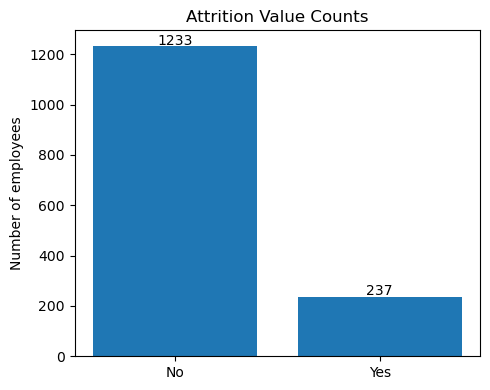

In [6]:
counts = df['Attrition'].value_counts()
print(counts)

fig, ax = plt.subplots(figsize=(5,4))
ax.bar(counts.index, counts.values)
ax.set_title('Attrition Value Counts')
ax.set_ylabel('Number of employees')
for i,v in enumerate(counts.values):
    ax.text(i, v+5, str(v), ha='center')
plt.tight_layout()
plt.show()


## 4. Distributions of Key Numeric Variables

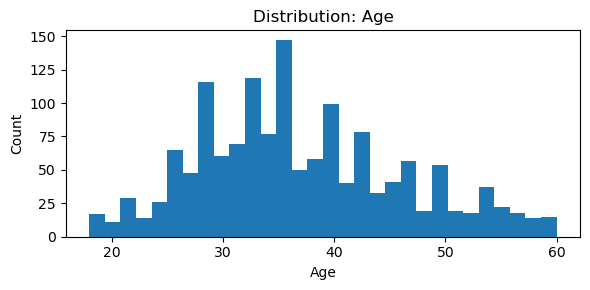

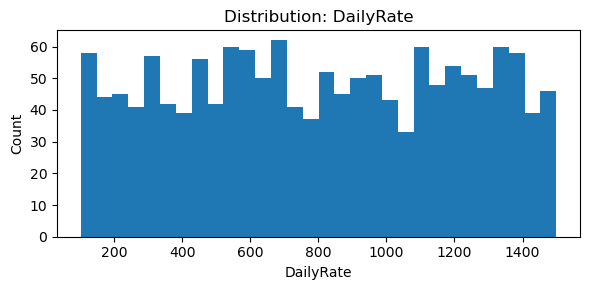

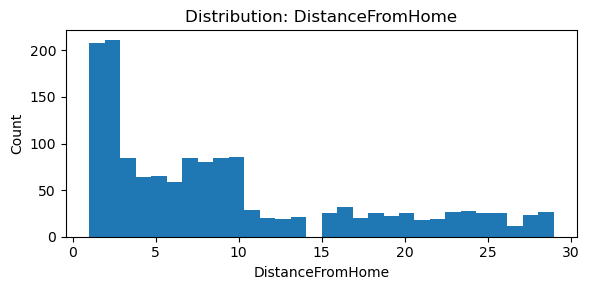

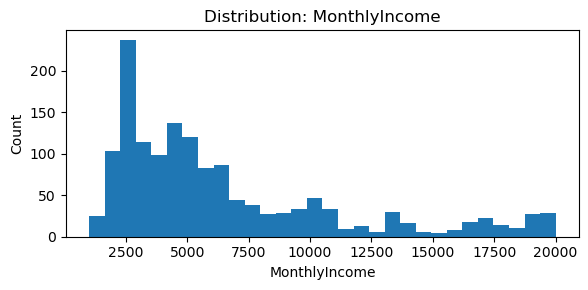

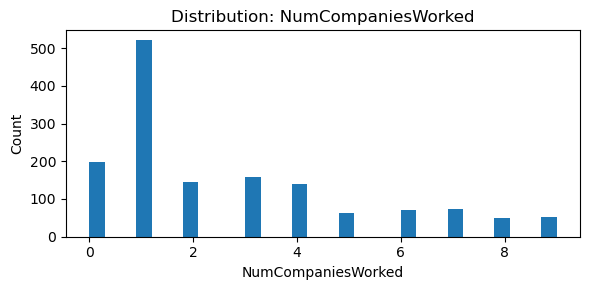

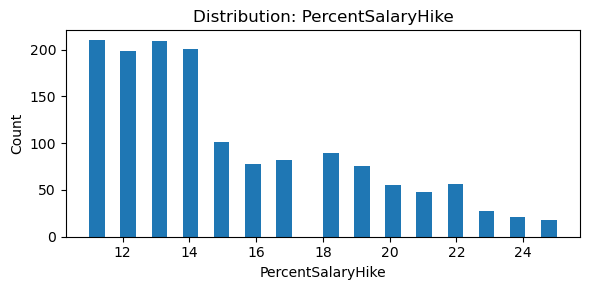

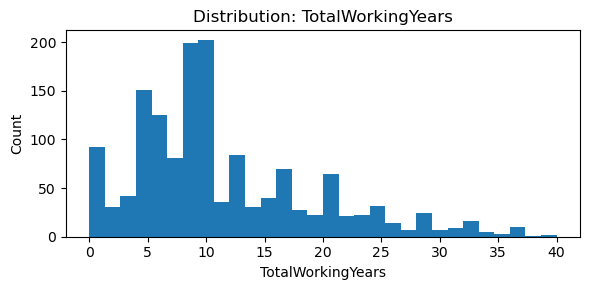

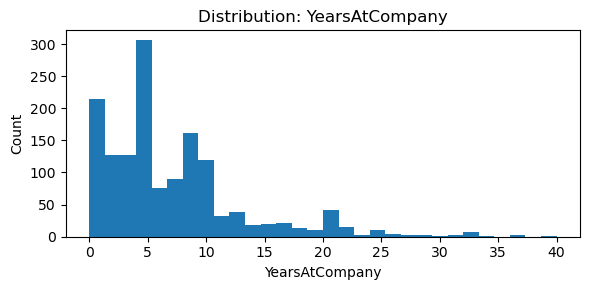

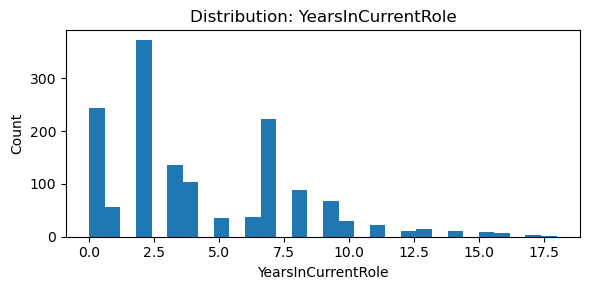

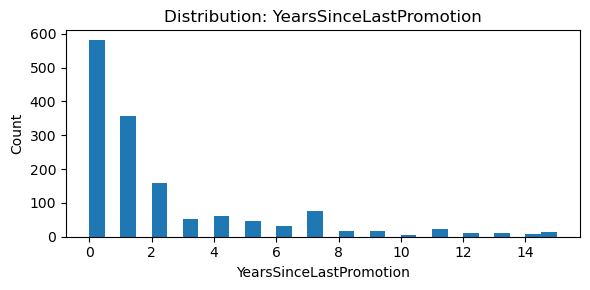

In [7]:
num_vars = ['Age','DailyRate','DistanceFromHome','MonthlyIncome','NumCompaniesWorked','PercentSalaryHike',
            'TotalWorkingYears','YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion']

for col in num_vars:
    fig, ax = plt.subplots(figsize=(6,3))
    ax.hist(df[col].dropna(), bins=30)
    ax.set_title(f'Distribution: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.show()


## 5. Numeric variables by Attrition (boxplots)

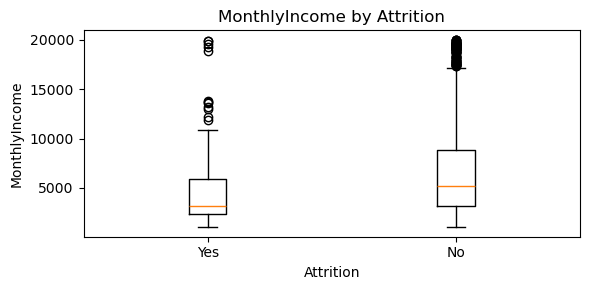

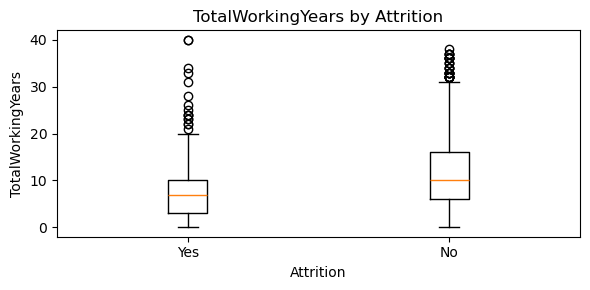

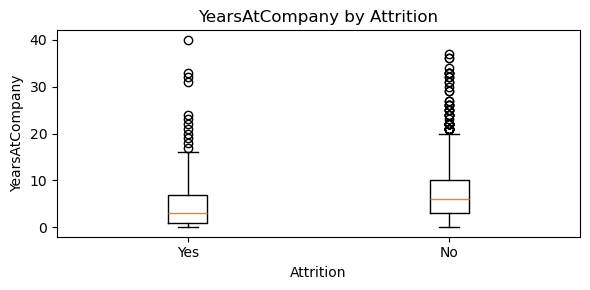

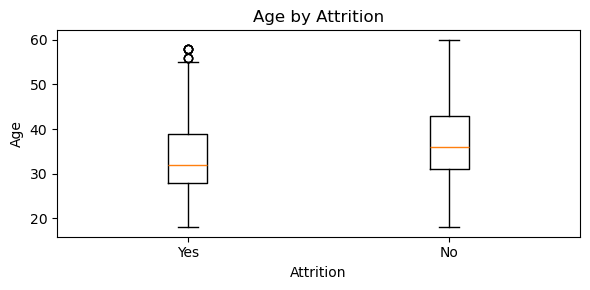

In [23]:
num_vars_small = ['MonthlyIncome','TotalWorkingYears','YearsAtCompany','Age']

for col in num_vars_small:
    fig, ax = plt.subplots(figsize=(6,3))
    
    groups = [df[df['Attrition'] == val][col].dropna() 
              for val in df['Attrition'].unique()]
    
    ax.boxplot(groups, tick_labels=df['Attrition'].unique())  # UPDATED
    
    ax.set_title(f'{col} by Attrition')
    ax.set_xlabel('Attrition')
    ax.set_ylabel(col)
    
    plt.tight_layout()
    plt.show()


## 6. Categorical variable breakdowns (bar charts)

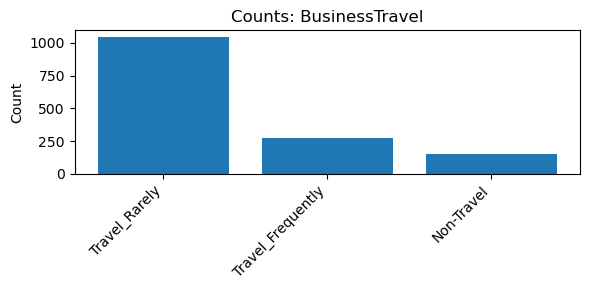

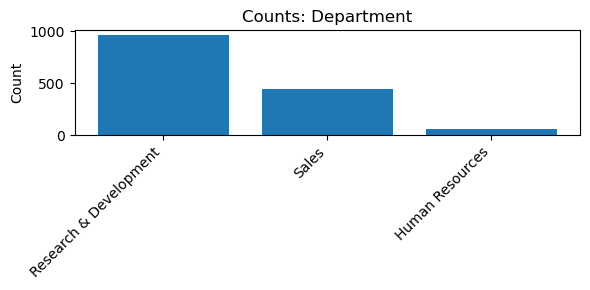

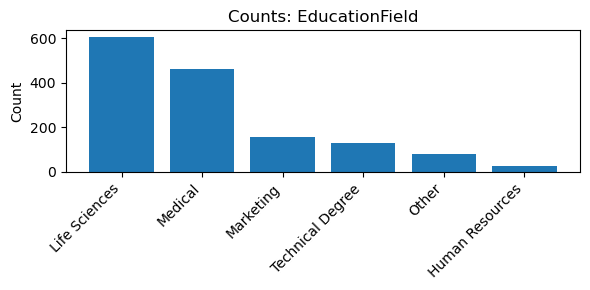

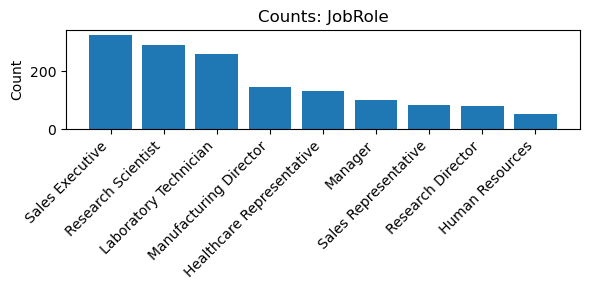

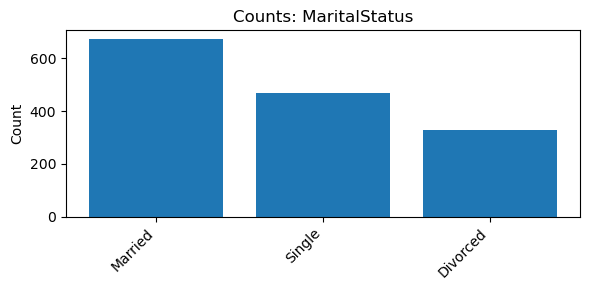

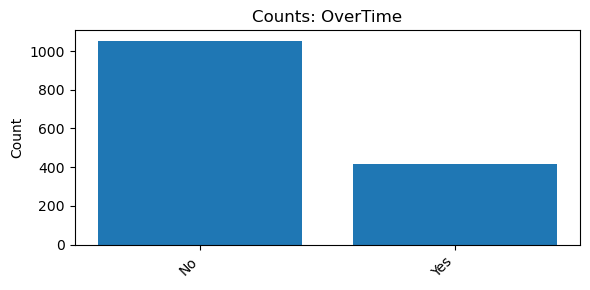

In [23]:
cat_vars = ['BusinessTravel','Department','EducationField','JobRole','MaritalStatus','OverTime']
for col in cat_vars:
    counts = df[col].value_counts()
    fig, ax = plt.subplots(figsize=(6,3))
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_title(f'Counts: {col}')
    ax.set_ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


## 7. Correlation Matrix (numeric features)

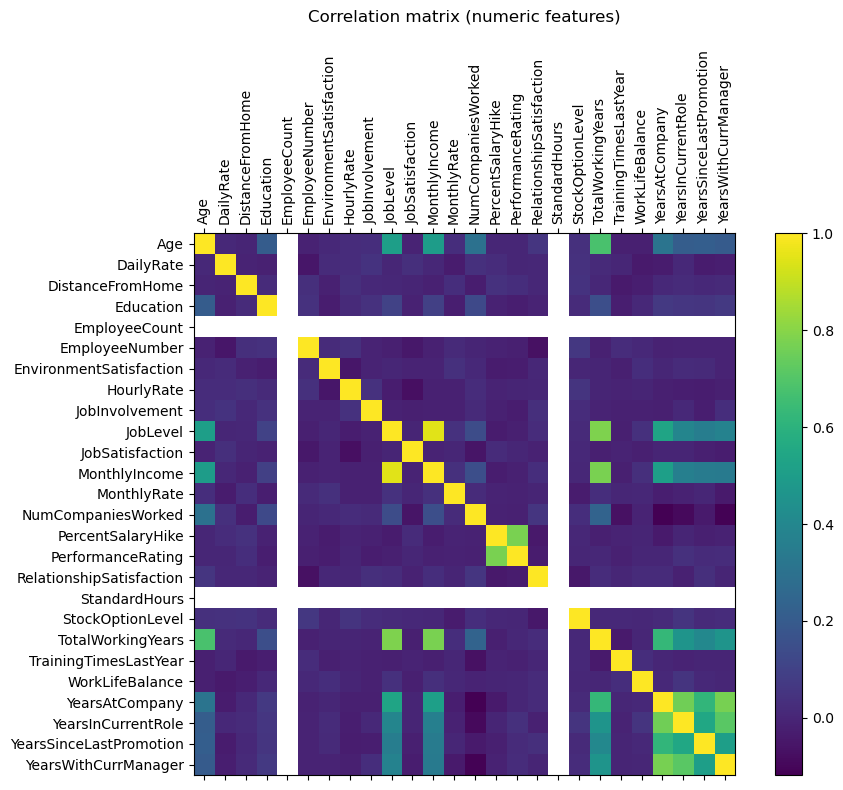

In [25]:
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()
fig, ax = plt.subplots(figsize=(10,8))
cax = ax.matshow(corr)
fig.colorbar(cax)
ax.set_xticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticks(range(len(corr.columns)))
ax.set_yticklabels(corr.columns)
ax.set_title('Correlation matrix (numeric features)', pad=20)
plt.tight_layout()
plt.show()


## 8. Feature Engineering and Preprocessing
- Encode categorical variables
- Create a 'tenure_ratio' feature = YearsAtCompany / TotalWorkingYears (where applicable)
- Prepare data for baseline model

In [13]:
df_fe = df.copy()
# tenure_ratio
df_fe['tenure_ratio'] = df_fe['YearsAtCompany'] / (df_fe['TotalWorkingYears'].replace(0, np.nan))
# fill infinite/null tenure_ratio with 0
df_fe['tenure_ratio'] = df_fe['tenure_ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Binary encoding for Attrition and OverTime
le = LabelEncoder()
df_fe['Attrition_flag'] = le.fit_transform(df_fe['Attrition'])  # Yes=1, No=0
# For modeling, we'll encode object columns with label encoding if 2 categories else one-hot
obj_cols = df_fe.select_dtypes(include=['object']).columns.tolist()
obj_cols


['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

In [14]:
# One-hot encode selected categorical variables (keeping dimensionality reasonable)
to_one_hot = ['BusinessTravel','Department','EducationField','JobRole','MaritalStatus']
df_model = pd.get_dummies(df_fe, columns=to_one_hot, drop_first=True)

# Select features for baseline model
features = ['Age','MonthlyIncome','TotalWorkingYears','YearsAtCompany','JobLevel','TrainingTimesLastYear',
            'PercentSalaryHike','OverTime','tenure_ratio']
# Ensure OverTime encoded as 1/0
if df_model['OverTime'].dtype == 'object':
    df_model['OverTime'] = LabelEncoder().fit_transform(df_model['OverTime'])

one_hot_cols = [c for c in df_model.columns if any(prefix in c for prefix in ['JobRole_','Department_','BusinessTravel_','EducationField_','MaritalStatus_'])]
one_hot_cols = one_hot_cols[:6]
features += one_hot_cols

X = df_model[features]
y = df_model['Attrition_flag']

print('Features used for baseline model:')
print(features)
X.shape, y.shape


Features used for baseline model:
['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'JobLevel', 'TrainingTimesLastYear', 'PercentSalaryHike', 'OverTime', 'tenure_ratio', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Research & Development', 'Department_Sales', 'EducationField_Life Sciences', 'EducationField_Marketing']


((1470, 15), (1470,))

## 9. Baseline Model: Logistic Regression
Train/test split, scaling, train logistic regression, and evaluate using accuracy, classification report, and ROC AUC.

Accuracy: 0.8532608695652174

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92       309
           1       0.65      0.19      0.29        59

    accuracy                           0.85       368
   macro avg       0.76      0.58      0.60       368
weighted avg       0.83      0.85      0.82       368

ROC AUC: 0.7472437057758762


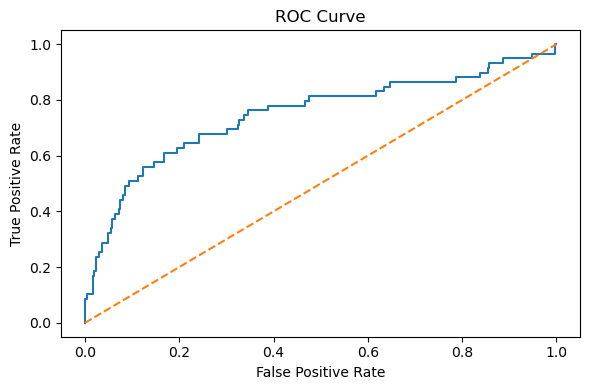

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
y_pred_proba = clf.predict_proba(X_test_scaled)[:,1]

print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(fpr, tpr)
ax.plot([0,1],[0,1], linestyle='--')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.tight_layout()
plt.show()


### Feature importance (logistic regression coefficients)

In [24]:
coefs = pd.Series(clf.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
coefs.head(20)

OverTime                             0.633236
BusinessTravel_Travel_Frequently     0.530152
Age                                 -0.430294
BusinessTravel_Travel_Rarely         0.276183
Department_Research & Development   -0.219766
YearsAtCompany                      -0.190121
tenure_ratio                        -0.186698
TotalWorkingYears                   -0.170304
JobLevel                            -0.150220
MonthlyIncome                       -0.141796
TrainingTimesLastYear               -0.127249
Department_Sales                     0.118895
EducationField_Marketing             0.050117
PercentSalaryHike                   -0.034197
EducationField_Life Sciences         0.007271
dtype: float64

## 10. Data Cleaning Summary
- No missing values in original IBM dataset, but we created safe handling for derived fields.
- Duplicates checked and reported earlier.
- Encoded categorical variables and created tenure_ratio feature.

## 11. Next steps (Module 24)
- Try tree-based models (Random Forest, XGBoost) and tune hyperparameters.
- Add more feature engineering (interaction terms, grouping low-count categories).
- Prepare final visualizations for presentation-ready slides or report.


# Predictive Modeling: Employee Attrition

**Business goal:** Predict whether an employee will leave ("Attrition" = Yes) so HR can intervene early with targeted retention actions.

**Modeling note:** Attrition is usually a minority class. Accuracy can look “good” while still missing most leavers, so we focus on:
- **ROC-AUC** (ranking quality)
- **Recall (Attrition=Yes)** and **F1** (catching leavers without too many false alarms)
- **Average Precision / PR-AUC** (useful for imbalanced data)


In [8]:
# -----------------------------
# 1) Train/test split
# -----------------------------
df_model = df.copy()

# Target
y = df_model["Attrition"].map({"Yes": 1, "No": 0})

# Drop obvious identifier-like / constant columns if present (defensive)
drop_cols = [c for c in ["EmployeeCount", "Over18", "StandardHours"] if c in df_model.columns]
X = df_model.drop(columns=["Attrition"] + drop_cols)

# Train/test (holdout test set used only once at the end)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " | Test size:", X_test.shape)
print("Attrition rate (train):", y_train.mean().round(3), " | (test):", y_test.mean().round(3))


Train size: (1102, 31)  | Test size: (368, 31)
Attrition rate (train): 0.162  | (test): 0.16


## 11. Preprocessing Pipeline

We build a single pipeline that:
- imputes missing values (if any appear after feature engineering),
- scales numeric columns,
- one-hot encodes categorical columns,
- trains a classifier.

This makes cross-validation and grid search clean and leak-free.


In [9]:
# Identify column types
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = [c for c in X_train.columns if c not in num_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop"
)

preprocess


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'DailyRate', 'DistanceFromHome',
                                  'Education', 'EmployeeNumber',
                                  'EnvironmentSatisfaction', 'HourlyRate',
                                  'JobInvolvement', 'JobLevel',
                                  'JobSatisfaction', 'MonthlyIncome',
                                  'MonthlyRate', 'NumCompaniesWorked',
                                  'PercentSalaryHik...
                                  'TrainingTimesLastYear', 'WorkLifeBalance',
                                  'YearsAtCompany', 'YearsInCurrentRole',
                                  'YearsSinceLastPromotion',
                                  'YearsWithCurrManager']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['BusinessTravel', 'Department',
                                  'EducationField', 'Gender', 'JobRole',
                                  'MaritalStatus', 'OverTime'])])

## 12. Model Comparison with Cross-Validation

We compare multiple classifiers using **Stratified K-Fold CV**.

Models tested:
- Logistic Regression (interpretable baseline)
- Random Forest (nonlinear + interactions)
- HistGradientBoosting (strong tabular baseline, often competitive)


In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LogReg (class_weight=balanced)": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=400),
    "HistGB": HistGradientBoostingClassifier(random_state=42),
}

scoring = {
    "roc_auc": "roc_auc",
    "f1": "f1",
    "recall": "recall",
    "precision": "precision",
    "avg_precision": "average_precision",
}

cv_rows = []
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    row = {"model": name}
    for m in scoring.keys():
        row[m] = np.mean(scores[f"test_{m}"])
    cv_rows.append(row)

cv_results = pd.DataFrame(cv_rows).sort_values("roc_auc", ascending=False)
cv_results


,model,roc_auc,f1,recall,precision,avg_precision
0,LogReg (class_weight=balanced),0.839395,0.523948,0.769841,0.397642,0.636258
1,RandomForest,0.814215,0.307852,0.191111,0.805000,0.568134
2,HistGB,0.787463,0.396940,0.286825,0.668485,0.526262


## 13. Hyperparameter Tuning (Grid Search)

We tune at least two models with GridSearchCV, using ROC-AUC as the primary selection metric.


In [11]:
# -----------------------------
# Grid Search: Logistic Regression
# -----------------------------
logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

logreg_param_grid = {
    "model__C": [0.1, 0.5, 1.0, 2.0, 5.0],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"],
}

logreg_grid = GridSearchCV(
    logreg_pipe,
    param_grid=logreg_param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)
logreg_grid.fit(X_train, y_train)

print("Best LogReg ROC-AUC:", logreg_grid.best_score_.round(4))
print("Best params:", logreg_grid.best_params_)


Best LogReg ROC-AUC: 0.8402
Best params: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


In [12]:
# -----------------------------
# Grid Search: Random Forest
# -----------------------------
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    "model__n_estimators": [300, 600],
    "model__max_depth": [None, 8, 14],
    "model__min_samples_leaf": [1, 3, 6],
    "model__class_weight": [None, "balanced"],
}

rf_grid = GridSearchCV(
    rf_pipe,
    param_grid=rf_param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)

print("Best RF ROC-AUC:", rf_grid.best_score_.round(4))
print("Best params:", rf_grid.best_params_)


Best RF ROC-AUC: 0.8148
Best params: {'model__class_weight': None, 'model__max_depth': 8, 'model__min_samples_leaf': 3, 'model__n_estimators': 300}


## 14. Final Model Selection and Holdout Test Evaluation

We pick the tuned model with the best cross-validated ROC-AUC, then evaluate once on the holdout test set.


In [13]:
best_candidates = [
    ("LogisticRegression", logreg_grid),
    ("RandomForest", rf_grid),
]

best_name, best_grid = max(best_candidates, key=lambda x: x[1].best_score_)
best_model = best_grid.best_estimator_

print("Selected model:", best_name)
print("CV ROC-AUC:", best_grid.best_score_.round(4))


Selected model: LogisticRegression
CV ROC-AUC: 0.8402


In [14]:
# Fit on full training data and evaluate on the holdout test set
best_model.fit(X_train, y_train)

# Predictions
y_pred = best_model.predict(X_test)

# Probabilities for ROC/PR metrics (some models expose predict_proba)
y_proba = best_model.predict_proba(X_test)[:, 1]

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_proba),
    "Avg Precision (PR-AUC)": average_precision_score(y_test, y_proba),
}

pd.Series(metrics).round(4)


Accuracy                  0.7772
Precision                 0.3861
Recall                    0.6610
F1                        0.4875
ROC-AUC                   0.8123
Avg Precision (PR-AUC)    0.5742
dtype: float64

In [15]:
# Classification report (kept concise)
print(classification_report(y_test, y_pred, target_names=["No Attrition", "Attrition"]))


              precision    recall  f1-score   support

No Attrition       0.93      0.80      0.86       309
   Attrition       0.39      0.66      0.49        59

    accuracy                           0.78       368
   macro avg       0.66      0.73      0.67       368
weighted avg       0.84      0.78      0.80       368



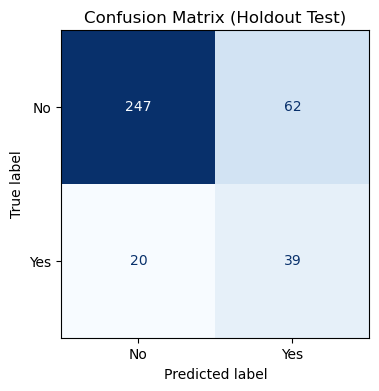

In [16]:
# Confusion matrix (visual)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, values_format="d", cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix (Holdout Test)")
plt.show()


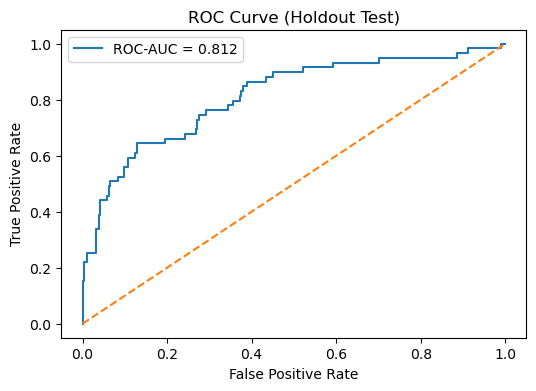

In [17]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(fpr, tpr, label=f"ROC-AUC = {metrics['ROC-AUC']:.3f}")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve (Holdout Test)")
ax.legend()
plt.show()


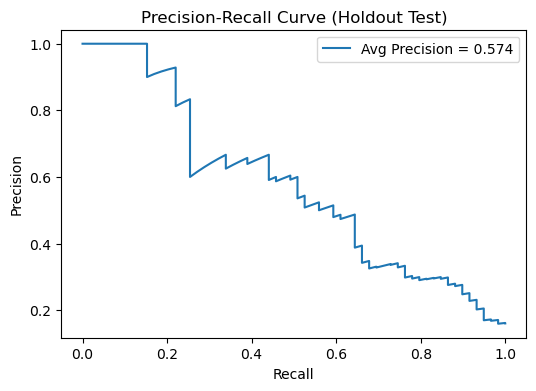

In [18]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = metrics["Avg Precision (PR-AUC)"]
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(recall, precision, label=f"Avg Precision = {ap:.3f}")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve (Holdout Test)")
ax.legend()
plt.show()


## 15. Model Interpretation

Two lightweight, capstone-friendly interpretation approaches:
- **Permutation importance** (model-agnostic)
- **Logistic regression coefficients** (if the selected model is logistic regression)


In [20]:
from sklearn.inspection import permutation_importance
import pandas as pd

sample_n = min(600, X_test.shape[0])
X_test_sample = X_test.iloc[:sample_n]
y_test_sample = y_test.iloc[:sample_n]

result = permutation_importance(
    best_model,
    X_test_sample,
    y_test_sample,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"
)

raw_feature_names = X_test_sample.columns  # <-- key change
importances = (
    pd.Series(result.importances_mean, index=raw_feature_names)
      .sort_values(ascending=False)
)

importances.head(15)


OverTime                   0.097559
YearsSinceLastPromotion    0.025243
JobSatisfaction            0.021886
NumCompaniesWorked         0.021480
EnvironmentSatisfaction    0.019516
MaritalStatus              0.019368
BusinessTravel             0.015720
MonthlyIncome              0.012177
YearsWithCurrManager       0.009879
StockOptionLevel           0.009692
JobInvolvement             0.009517
TrainingTimesLastYear      0.007591
Gender                     0.007465
YearsAtCompany             0.007454
JobRole                    0.006730
dtype: float64

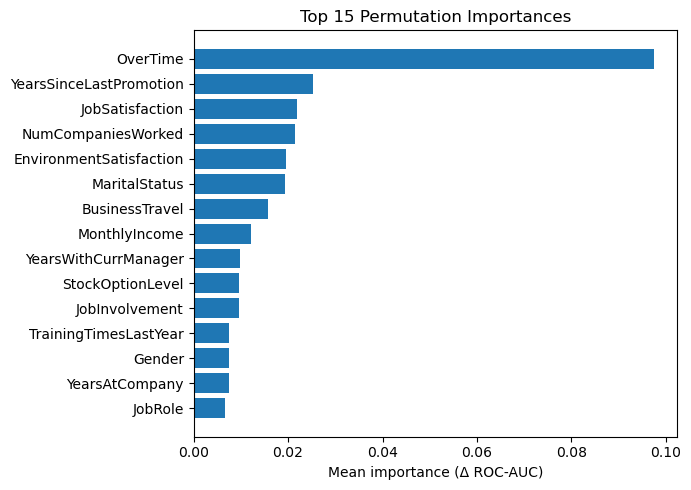

In [21]:
# Plot top permutation importances
topk = 15
top_imp = importances.head(topk).sort_values()
fig, ax = plt.subplots(figsize=(7,5))
ax.barh(top_imp.index, top_imp.values)
ax.set_xlabel("Mean importance (Δ ROC-AUC)")
ax.set_title(f"Top {topk} Permutation Importances")
plt.tight_layout()
plt.show()


In [22]:
# If final model is Logistic Regression, show signed coefficients (interpretability)
if best_name == "LogisticRegression":
    lr = best_model.named_steps["model"]
    coef_series = pd.Series(lr.coef_[0], index=feature_names).sort_values()
    print("Most negative (lower attrition risk):")
    print(coef_series.head(10).round(3))
    print("\nMost positive (higher attrition risk):")
    print(coef_series.tail(10).round(3))
else:
    print("Final model is not Logistic Regression; coefficients are not available.")


Most negative (lower attrition risk):
OverTime_No                         -0.688
BusinessTravel_Non-Travel           -0.539
JobRole_Healthcare Representative   -0.386
YearsWithCurrManager                -0.369
EnvironmentSatisfaction             -0.361
JobSatisfaction                     -0.339
JobRole_Research Director           -0.336
Department_Research & Development   -0.333
TotalWorkingYears                   -0.332
Age                                 -0.304
dtype: float64

Most positive (higher attrition risk):
EducationField_Human Resources      0.203
DistanceFromHome                    0.276
Department_Sales                    0.315
NumCompaniesWorked                  0.386
JobRole_Sales Representative        0.404
MaritalStatus_Single                0.412
YearsSinceLastPromotion             0.438
BusinessTravel_Travel_Frequently    0.572
JobRole_Laboratory Technician       0.642
OverTime_Yes                        0.688
dtype: float64


# Findings, Recommendations, and Next Steps

## Key Findings (example framing — update after you run the notebook)
- Attrition is a minority class; **recall** and **PR-AUC** are important so we don’t miss leavers.
- The best model achieved a solid **ROC-AUC** and **PR-AUC** on a holdout set, indicating useful predictive signal.
- Top drivers (from importance / coefficients) typically include compensation, tenure, overtime, role level, travel, and work-life balance.

## Recommendations (non-technical language)
- Use the model as an **early warning** tool: flag higher-risk employees for proactive engagement, not punitive action.
- Pair predictions with **explainability** (top contributing factors) to guide targeted interventions (career development, workload, manager coaching, comp review).

